# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "yoni schirris"
NAME2 = "tycho grouwstra"
NAME3 = ""
EMAIL = "yschirris@gmail.com"
EMAIL2 = "tychogrouwstra@gmail.com"
EMAIL3 = ""

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$

## Part 1: Polynomial Regression

### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\bx$ and $\bt$, where $\bx$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\bt$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$.


In [4]:
def gen_sine(n):
    """
    generates toy data like in fig 1.2 of Bishop's book.
    parameters:
      n
    returns: tuple of n-dimensional vectors (x, t)
      x: contains evenly spaced values from 0 to (including) 2 pi
      t: values distributed according to: $$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$
    where:
      $x_i$ is the $i$-th elements of $\bf{x}$
      the mean $\mu_i = \sin(x_i)$
      the standard deviation $\sigma = 0.25$
    """
    radians = lambda i: i * (math.pi*2)/(n-1)
    gauss = lambda rad: np.random.normal(loc=np.sin(rad), scale=0.25)
    rng = np.array(range(0,n))
    x = radians(rng)
    t = gauss(x)
    return x, t


In [5]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\bw$ is:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$

where $\bPhi$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\bt$ is the vector of target values. Your method should return a vector $\bw$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\bPhi$.

In [6]:
from numpy.linalg import inv

def designmatrix(x, M):
    """
    computes the feature matrix Phi, where phi is a vector of functions of the Mth-order polynomial:
    PHI =      phi0(x_1)    ...   phi_m-1(x_1)
               ...          ...   ...
               phi0(x_N)    ...   phi_m-1(x_N)
    where features phi = [x^0, x^1, x^2, ...]^T
    """
    ms = range(M+1)
    phi = np.array([[x_n**m for m in ms] for x_n in x])  # vstack?
    return phi

def fit_polynomial(x, t, M):
    """finds the maximum-likelihood solution of an unregularized Mth order polynomial for a dataset x"""
    phi = designmatrix(x, M)
    w_ml = inv(phi.T.dot(phi)).dot(phi.T).dot(t)
    return w_ml, phi


In [7]:
### Test your function
N = 10
x = np.square((np.linspace(-1, 1, N)))
t = 0.3*x + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

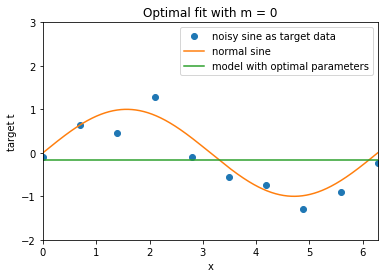

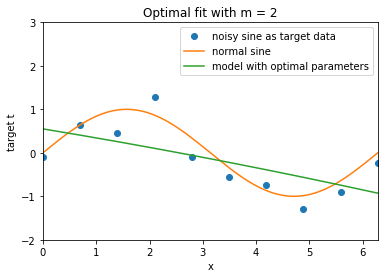

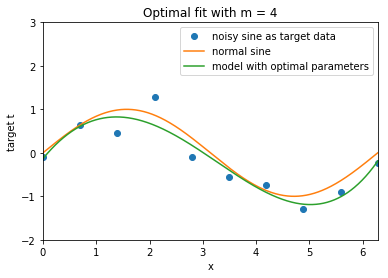

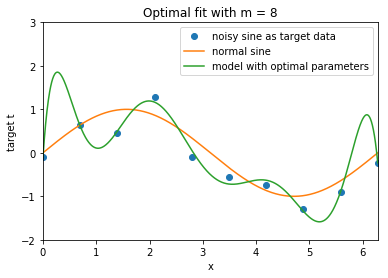

In [8]:
np.random.seed(2)
N = 10
M = [0, 2, 4, 8]

# t is the noisy sine
x, t = gen_sine(N)

# clean sine, without noise
actual_sine = list(map(math.sin, x))
fine_x, fine_t = gen_sine(N*100)
fine_actual_sine = list(map(math.sin, fine_x))

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(2, 2)

for idx, m in enumerate(M):
    i = math.floor(idx / 2)
    j = idx % 2
    # ax = axarr[i, j]

    w_ml, Phi = fit_polynomial(x, t, m)
    fine_Phi = fit_polynomial(fine_x, fine_t, m)[1]
    fine_fit_function = np.dot(fine_Phi, w_ml)
    fit_function = np.dot(Phi, w_ml)

    # plot the noisy sine as dots
    plt.plot(x, t, linestyle="", marker="o", label="noisy sine as target data")
    # plot the actual sine as a line
    plt.plot(fine_x, fine_actual_sine, label="normal sine")
    # plot the fit as a line
    plt.plot(fine_x, fine_fit_function, label="model with optimal parameters")
    plt.title("Optimal fit with m = " + str(m))
    plt.xlabel("x")
    plt.ylabel("target t")
    plt.legend(loc='upper right')
    axes = plt.gca()
    axes.set_xlim([0,2*pi])
    axes.set_ylim([-2,3])
    plt.figure()
    


### 1.4 Regularized linear regression (15 points)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\bw$:

$E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$

For background, see section 3.1.4 of Bishop's book.

The function should return $\bw$ and $\bPhi$.

In [9]:
def fit_polynomial_reg(x, t, m, lamb):
    Phi = designmatrix(x,m)
    f = Phi.T.dot(Phi)
    penalty = lamb * np.identity(len(f))
    w_ml = inv(penalty + f).dot(Phi.T).dot(t)
    return w_ml, Phi


In [10]:
### Test your function
N = 10
x = np.square((np.linspace(-1, 1, N)))
t = 0.3*x + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\bw$ and $\bPhi$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x + 2.5$)

We should see that the parameters become much smaller: Where before we were minimizing $E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt)$, we are now minimizing $E(\bw) = \frac{1}{2} (\bPhi\bw - \bt)^T(\bPhi\bw - \bt) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$. One can see that the inner product of the weights is added to the minimization problem. Therefore, the model 'enjoys' solutions that have a good fit with smaller weights. It then indeed finds a solution with smaller (closer to 0) parameters.

For example for M=2,  the optimal unregularized weights: $w_0$ = 0.91746727 $w_1$ = -0.38717519 $ w_2$ = 0.02549609, while the regularized weights are $w_0$ = 0.8519505  $w_1$ = -0.34378265$  w_2$ = 0.01978541, showing indeed weights that are closer to 0 for the regularized model.







### 1.5 Model selection by cross-validation (15 points)
Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [11]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    
    # train the model (the weights) on the training data    
    w = fit_polynomial_reg(x_train, t_train, M, reg)[0]
    
    #create a design matrix for the validation data    
    Phi = designmatrix(x_valid, M)
    
    #create all predicted targets
    t_pred = w.dot(Phi.T)
    
    pred_err = np.sum((t_pred - t_valid)**2)
    return pred_err


In [12]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [13]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [14]:
N = 10
M = list(range(0,10))
Lamb = [np.exp(-1*i) for i in M[::-1]]
x,t = gen_sine(N)
print('M', M)
print('Lamb', Lamb)


#TODO write formal test to verify best values
### If you want you can write your own test here

def fold_results(indices):
  train_indices, valid_indices = indices
  x_train = [x[i] for i in train_indices]
  x_valid = [x[i] for i in valid_indices]
  t_train = [t[i] for i in train_indices]
  t_valid = [t[i] for i in valid_indices]

  lst = [(
      pred_error(x_train, x_valid, t_train, t_valid, m, lamb),
      m,
      lamb
    ) for m in M for lamb in Lamb]
  # transpose to get (errors, ms, lambs) instead of [(error), m, lamb]
  return list(map(list, zip(*lst)))

def find_best_m_and_lamb(x, t):
    k = 5
    N = len(x)
    # k folds of indices used for training (8) / validation (2) items
    folds = numpy.array(kfold_indices(N, k)).T
    results = list(map(fold_results, folds))

    # these should be 100 rows, 5 columns, holding the 100 errors for each fold
    error_results = np.vstack([np.array(results[i][0]) for i in range(k)])

    # this should be 100 rows, 1 column, holding the average of all folds    
    averaged_results = np.average(error_results, axis=0)
    # print("averaged_results" , averaged_results)
    
    # then we could take the max, get its index, and get the accompanying M and lamb
    M_best = results[0][1][np.argmin(averaged_results)]
    lamb_best = results[0][2][np.argmin(averaged_results)]
    
    # print('averaged_results', averaged_results)
    print("The lowest error is ", min(averaged_results))
    return M_best, lamb_best
  
M_best, lamb_best = find_best_m_and_lamb(x, t)
print("Best M = ", M_best)
print("Best lambda = ", lamb_best)


M [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Lamb [0.00012340980408667956, 0.00033546262790251185, 0.00091188196555451624, 0.0024787521766663585, 0.006737946999085467, 0.018315638888734179, 0.049787068367863944, 0.1353352832366127, 0.36787944117144233, 1.0]
The lowest error is  0.0614946287922
Best M =  5
Best lambda =  0.0497870683679


In [15]:
### If you want you can write your own test here

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

This would ignore the effect that one parameter has on the other parameter. The hyperparameters are very likely not independently influencing the model. Optimizing one variable while holding another variable constant might (highly likely) not yield the optimal answer. Therefore, all possible combinations should be tested.

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

Evolutionary algorithms form an effective alternative to grid search here. Although these use no inherent knowledge of our hyper-parameter tuning domain, they form a smarter alternative to brute-forcing by combining exploration and exploitation to find good solutions without focusing too much on less effective areas of the hyper-parameter search space.


### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

(-2, 3)

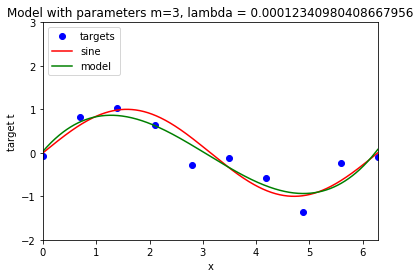

In [16]:
np.random.seed(6)
N = 10
m = 3
lamb = math.exp(-9)
x,t = gen_sine(N)

fine_x, fine_t = gen_sine(N*100)
w_ml, Phi = fit_polynomial(x, t, m)
fine_Phi = fit_polynomial(fine_x, fine_t, m)[1]
fine_fit_function = np.dot(fine_Phi, w_ml)
fit_function = np.dot(Phi, w_ml)

plt.figure()
plt.title("Model with parameters m=" + str(m) + ", lambda = " + str(lamb))
# plot the noisy sine as dots
plt.plot(x, t, '-b', linestyle="", marker="o", label='targets')
# plot the actual sine as a line
plt.plot(fine_x, fine_actual_sine, '-r', label='sine')
# plot the fit as a line
plt.plot(fine_x, fine_fit_function, 'g', label='model')
pylab.legend(loc='upper left')
plt.plot()
plt.xlabel("x")
plt.ylabel("target t")
axes = plt.gca()
axes.set_xlim([0,2*pi])
axes.set_ylim([-2,3])


## Part 2: Bayesian Linear (Polynomial) Regression

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [17]:
def gen_sine2(n):
    x = np.random.uniform(0, 2*math.pi, n)
    gauss = lambda rad: np.random.normal(loc=np.sin(x), scale=0.25)
    t = gauss(x)
    return x, t
    

In [18]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\bw \;|\; \alpha) = \mathcal{N}(\bw \;|\; 0, \alpha^{-1} \bI)$$

The covariance and mean of the posterior are given by:

$$\bS_N= \left( \alpha \bI + \beta \bPhi^T \bPhi \right)^{-1} $$
$$\bm_N = \beta\; \bS_N \bPhi^T \bt$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\bm_N$ and covariance $\bS_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\bPhi$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [19]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    Phi = designmatrix(x, M)
    S = np.linalg.inv(alpha*np.identity(len(Phi.T.dot(Phi))) + beta*Phi.T.dot(Phi))
    m = beta*S.dot(Phi.T).dot(t)
    return m, S, Phi


In [20]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \bx, \bt, \alpha, \beta) = \mathcal{N}(t \;|\; \bm_N^T \phi(\bx), \sigma_N^2(\bx))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

where $\phi(\bx)$ are the computed features for a new datapoint $\bx$, and $t$ is the predicted variable for datapoint $\bx$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\bPhi$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [21]:
def predict_polynomial_bayes(x, m, S, beta):   

    def calc_poly_bayes(data):
      phi = np.array([data**i for i in range(len(S))])
      sig = 1/beta + phi.T.dot(S).dot(phi)
      avg = m.T.dot(phi)
      return (phi, sig, avg)

    lst = map(calc_poly_bayes, x)
    [Phi, sigma, mean] = map(np.array, zip(*lst))
    return mean, sigma, Phi


In [22]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and a 1-sigma predictive variance using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


(-2, 3)

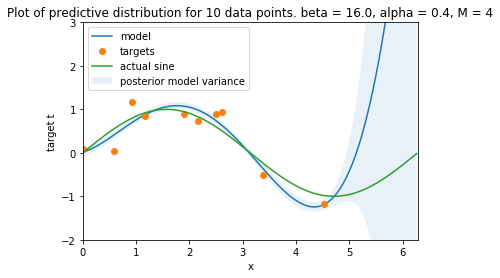

In [23]:
np.random.seed(1)
N = 10
M=4
alpha = 2/5
beta = 1/(0.25**2)

x,t = gen_sine2(N)
fine_x, fine_t = gen_sine2(100*N)
sort_by_first = lambda a, b: (list(t) for t in zip(*sorted(zip(a, b))))
x, t = sort_by_first(x, t)
fine_x, fine_t = sort_by_first(fine_x, fine_t)

mean_, S, _Phi = fit_polynomial_bayes(x, t, M, alpha, beta)
mean, sigma, _Phi = predict_polynomial_bayes(fine_x, mean_, S, beta)

plt.figure()
plt.plot(fine_x, mean, label="model")
plt.fill_between(fine_x, mean-sigma, mean+sigma, alpha=0.1, label="posterior model variance")

plt.plot(x, t, linestyle="", marker="o", label="targets" )
plt.plot(fine_x, [math.sin(data) for data in fine_x], label="actual sine")
plt.title("Plot of predictive distribution for {} data points. beta = {}, alpha = {}, M = {}".format(N, beta, alpha, M))
plt.xlabel("x")
plt.ylabel("target t")
pylab.legend(loc='upper left')

axes = plt.gca()
axes.set_xlim([0,2*pi])
axes.set_ylim([-2,3])


b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


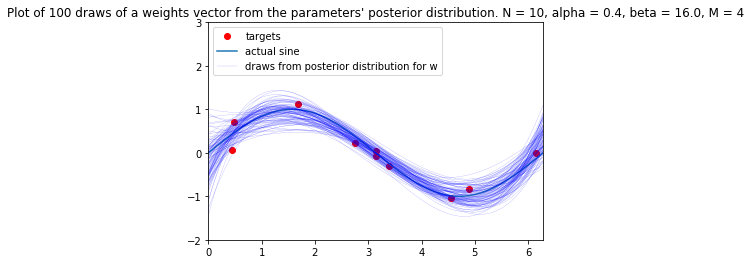

In [24]:
np.random.seed(7)
N = 10
M=4
alpha = 2/5
beta = 1/(0.25**2)

x, t = gen_sine2(N)
fine_x, fine_t = gen_sine2(1000*N)
sort_by_first = lambda a, b: (list(t) for t in zip(*sorted(zip(a, b))))
x, t = sort_by_first(x, t)
fine_x, fine_t = sort_by_first(fine_x, fine_t)
mean, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)
fine_mean, fine_s, fine_Phi = fit_polynomial_bayes(fine_x, fine_t, M, alpha, beta)

plt.figure()
axes = plt.gca()
axes.set_xlim([0,2*pi])
axes.set_ylim([-2,3])

plt.plot(x, t, 'red' , linestyle="", marker="o", label="targets")
plt.plot(fine_x, [math.sin(data) for data in fine_x], label="actual sine")
plt.title("Plot of 100 draws of a weights vector from the parameters' posterior distribution. N = {}, alpha = {}, beta = {}, M = {}".format(N, alpha, beta, M))

for i in range(100):
  w = np.random.multivariate_normal(mean=mean, cov=S )
  y = fine_Phi.dot(w)
  if i == 1:
    plt.plot(fine_x, y, 'blue', linewidth=0.1, label="draws from posterior distribution for w")
  else:
    plt.plot(fine_x, y, 'blue', linewidth=0.1)
  
pylab.legend(loc='upper left')



### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=\frac{1}{0.25^2}$ the best choice of $\beta$ in section 2.4?



$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\bx)^T \bS_N \phi(\bx) $$

Where $\bS_N$$\rightarrow 0$ as $N \rightarrow \infty$, leaving the actual $ \sigma^2 = \frac{1}{\beta} $, where we will put in the beta used to generate the data, in this case `0.25^2`

<!-- 
For a higher beta the noise will have a higher variance, making it harder to see the pattern through the data.
For a low beta, however, the noise is so low that fitting the underlying function becomes near trivial.
 -->

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

The challenge is to choose basis functions that will result in features that complement each other to such an extent as to be sufficient to generate a predictive model from. You can make the model (number and type of basis functions) more complex, but then you risk overfitting. You can make the model less complex, but then you risk not fitting enough. The challenge is to find the right balance between complexity and fit.



In [25]:
quickref